# Wines Points prediction 

In [38]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append('../')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Here we will try to predict the points a wine will get based on known characteristics (i.e. features, in the ML terminology). The mine point in this stage is to establish a simple, ideally super cost effective, basline.
In the real world there is a tradeoff between complexity and perforamnce, and the DS job, among others, is to present a tradeoff tables of what performance is achivalbel at what complexity level. 

to which models with increased complexity and resource demands will be compared. Complexity should then be translated into cost. For example:
 * Compute cost 
 * Maintenance cost
 * Serving costs (i.e. is new platform needed?) 
 

## Loading the data

In [39]:
import pandas as pd
import cufflinks as cf; cf.go_offline()

In [40]:
wine_reviews = pd.read_csv("data/winemag-data-130k-v2.csv")
wine_reviews.shape

(129971, 14)

In [41]:
wine_reviews.sample(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
37026,37026,Australia,"This plush, fruit-driven style of Shiraz displ...",Covenant,92,40.0,South Australia,Clare Valley,NaN,Joe Czerwinski,@JoeCz,Kilikanoon 2008 Covenant Shiraz (Clare Valley),Shiraz,Kilikanoon
79393,79393,New Zealand,This blend of four Bordeaux varieties (40% Cab...,Gimblett Gravels The Gimblett,90,30.0,Hawke's Bay,NaN,NaN,Joe Czerwinski,@JoeCz,Trinity Hill 2013 Gimblett Gravels The Gimblet...,Bordeaux-style Red Blend,Trinity Hill
9422,9422,US,"This has restrained aromas of char, cassis, sp...",Diavolo,83,36.0,New Mexico,New Mexico,NaN,NaN,NaN,Vivác Winery 2008 Diavolo Red (New Mexico),Red Blend,Vivác Winery
67293,67293,US,"This medium-bodied wine is fresh and fruity, b...",Estate Infrared,89,31.0,California,Livermore Valley,Central Coast,Jim Gordon,@gordone_cellars,Fenestra 2010 Estate Infrared Red (Livermore V...,Rhône-style Red Blend,Fenestra
50668,50668,Chile,This is a punchy wine that's fresh on the nose...,Quinta Generación,87,28.0,Colchagua Valley,NaN,NaN,Michael Schachner,@wineschach,Casa Silva 2010 Quinta Generación White (Colch...,White Blend,Casa Silva


In [42]:
wine_reviews = wine_reviews.drop(columns=['Unnamed: 0'])

In [43]:
wine_reviews = wine_reviews.drop_duplicates()
wine_reviews.shape

(119988, 13)

In [44]:
wine_reviews['desc_low'] = wine_reviews['description'].str.lower()
wine_reviews.sample()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,desc_low
10909,France,"Still young, this rich, lightly honeyed and in...",Le Grand Roc,93,40.0,Loire Valley,Sancerre,NaN,Roger Voss,@vossroger,Domaine Gérard Fiou 2015 Le Grand Roc (Sancerre),Sauvignon Blanc,Domaine Gérard Fiou,"still young, this rich, lightly honeyed and in..."


## Points prediction

Points is descrete value target. There for we are talking about a prediction (Regression) problem (in contrary to classification problem). Prediction solutions can be measured in few metrics:

* MSE - [Mean score error](https://en.wikipedia.org/wiki/Mean_squared_error)
* R2 - [R Square](https://en.wikipedia.org/wiki/Coefficient_of_determination)
* MAE - [Mean absolut error](https://en.wikipedia.org/wiki/Mean_absolute_error)

Read more [here](https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b)

### Train and test set split

To properly report results, let's split to train and test datasets:

In [45]:
train_data = wine_reviews.sample(frac = 0.8)
test_data = wine_reviews[~wine_reviews.index.isin(train_data.index)]
assert(len(train_data) + len(test_data) == len(wine_reviews))

In [46]:
len(test_data), len(train_data)

(23998, 95990)

### Baselines

In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [48]:
def calc_prediction_quality(df, pred_score_col, true_score_col):
    return pd.Series({'MSE': mean_squared_error(df[true_score_col], df[pred_score_col]),
                      'MAE': mean_absolute_error(df[true_score_col], df[pred_score_col]),
                      'R2': r2_score(df[true_score_col], df[pred_score_col])})

#### Baseline 1

The most basic baseline is simply the average points. The implementaion is as simple as:

In [49]:
test_data['basiline_1_predicted_points'] = train_data.points.mean()
b1_stats = calc_prediction_quality(test_data, 'basiline_1_predicted_points', 'points')
b1_stats

MSE    9.534127
MAE    2.524274
R2    -0.000082
dtype: float64

#### Basline 2

We can probably improve by predicting the average score based on the origin country:

In [50]:
avg_points_by_country = train_data.groupby('country').points.mean()
avg_points_by_country.head()

country
Argentina                 86.658882
Armenia                   87.500000
Australia                 88.595306
Austria                   90.146021
Bosnia and Herzegovina    86.500000
Name: points, dtype: float64

In [51]:
test_data['basiline_2_predicted_points'] = test_data.country.map(avg_points_by_country).fillna(train_data.points.mean())
b2_stats = calc_prediction_quality(test_data, 'basiline_2_predicted_points', 'points')
b2_stats

MSE    9.034840
MAE    2.454526
R2     0.052291
dtype: float64

#### Baseline 3

Adding more breakdowns will increase our granularity but can result in overfitting. Yet:

In [52]:
avg_points_by_country_and_region = train_data.groupby(['country','province']).points.mean().rename('basiline_3_predicted_points')
avg_points_by_country_and_region.head()

country    province        
Argentina  Mendoza Province    86.786332
           Other               85.879093
Armenia    Armenia             87.500000
Australia  Australia Other     85.250000
           New South Wales     87.783333
Name: basiline_3_predicted_points, dtype: float64

In [53]:
test_data_with_baseline_3 = test_data.merge(avg_points_by_country_and_region, on = ['country','province'], how='left')
test_data_with_baseline_3.basiline_3_predicted_points = test_data_with_baseline_3.basiline_3_predicted_points.fillna(test_data_with_baseline_3.basiline_2_predicted_points).fillna(test_data.basiline_1_predicted_points)
test_data_with_baseline_3.shape, test_data.shape

((23998, 17), (23998, 16))

In [54]:
b3_stats = calc_prediction_quality(test_data_with_baseline_3, 'basiline_3_predicted_points', 'points')
b3_stats

MSE    8.497766
MAE    2.362510
R2     0.108628
dtype: float64

### Baselines summary

In [55]:
baseline_summary = pd.DataFrame([b1_stats, b2_stats, b3_stats], index=['baseline_1', 'baseline_2','baseline_3'])
baseline_summary

,MSE,MAE,R2
baseline_1,9.534127,2.524274,-0.000082
baseline_2,9.034840,2.454526,0.052291
baseline_3,8.497766,2.362510,0.108628


In [56]:
baseline_summary.to_csv('data/baselines_summary.csv', index=False)

## Training a Boosting trees regressor

In [57]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#### Preparing data - Lable encoding categorical features

In [58]:
categorical_features = ['country','province','region_1','region_2','taster_name','variety','winery']
numerical_features = ['price']
features = categorical_features + numerical_features

In [59]:
encoded_features = wine_reviews[categorical_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
encoded_features['price'] = wine_reviews.price.fillna(-1)
encoded_features['points'] = wine_reviews.points
encoded_features.head()

,country,province,region_1,region_2,taster_name,variety,winery,price,points
0,22,332,424,6,9,691,11608,-1.0,87
1,32,108,738,6,16,451,12956,15.0,87
2,41,269,1218,17,15,437,13018,14.0,87
3,41,218,549,6,0,480,14390,13.0,87
4,41,269,1218,17,15,441,14621,65.0,87


#### Re-splitting to train and test

In [60]:
train_encoded_features = encoded_features[encoded_features.index.isin(train_data.index)]
test_encoded_features = encoded_features[encoded_features.index.isin(test_data.index)]
assert(len(train_encoded_features) + len(test_encoded_features) == len(wine_reviews))

#### Fitting a tree-regressor

In [61]:
from src.models import i_feel_lucky_xgboost_training

In [62]:
train_encoded_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95990 entries, 0 to 129969
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      95990 non-null  int32  
 1   province     95990 non-null  int32  
 2   region_1     95990 non-null  int32  
 3   region_2     95990 non-null  int32  
 4   taster_name  95990 non-null  int32  
 5   variety      95990 non-null  int32  
 6   winery       95990 non-null  int32  
 7   price        95990 non-null  float64
 8   points       95990 non-null  int64  
dtypes: float64(1), int32(7), int64(1)
memory usage: 4.8 MB


In [ ]:
xgb_clf, clf_name = i_feel_lucky_xgboost_training(train_encoded_features, test_encoded_features, features, 'points', name='xgb_clf_points_prediction')

Let's look at the function output - specifically the **xgb_clf_points_prediction** column:

In [ ]:
test_encoded_features.head()

In [ ]:
xgb_stats = calc_prediction_quality(test_encoded_features, 'xgb_clf_points_prediction','points')
xgb_stats

In [ ]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb'])
all_compared

In [ ]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

## Classical NLP approaches

### Using only the text from the "description" column

### Data exploration

In [63]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [64]:
stopwords=nltk.corpus.stopwords.words("english")
stopwords[:5]

['i', 'me', 'my', 'myself', 'we']

#### Creating vocabulary from the Train set only:

In [65]:
all_words = [word for desc in train_data.desc_low for word in nltk.word_tokenize(desc) if word.lower() not in stopwords] # Words without stop words
words_df = pd.DataFrame(data = all_words, columns = ['word']).word.value_counts().reset_index()
words_df.columns = ['word','wordCount']
words_df['wordImportance'] = len(words_df) / words_df.wordCount / words_df.wordCount.max()
words_df.head()

,word,wordCount,wordImportance
0,",",326411,3.875952e-07
1,.,261231,4.843045e-07
2,wine,58977,2.145164e-06
3,flavors,46476,2.722165e-06
4,'s,38329,3.300773e-06


In [66]:
words_df.shape

(41296, 3)

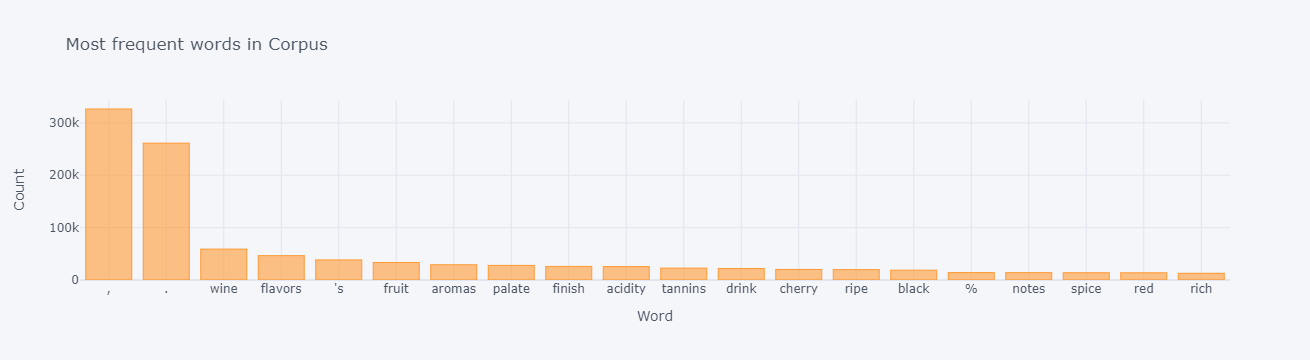

In [67]:
words_df.set_index('word').wordCount.head(20).iplot(kind = 'bar', title = 'Most frequent words in Corpus', yTitle = 'Count', xTitle = 'Word')

In [68]:
print("Total of {} words, {} unique words".format(len(all_words), len(words_df)))

Total of 3047217 words, 41296 unique words


In [69]:
print ("Using words with 4 or more appearances will reduce the corpus size to: {}".format(sum(words_df.wordCount >= 4)))

Using words with 4 or more appearances will reduce the corpus size to: 14012


In [70]:
words_df = words_df[words_df.wordCount >= 4]

#### Bag of words (One-hot-encoding) for Train

In [71]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [72]:
clean_vocab = set(words_df.word)

In [73]:
count_vect = CountVectorizer(vocabulary = clean_vocab, tokenizer=nltk.word_tokenize)

In [74]:
clean_bow_counts_train = count_vect.fit_transform(train_data.desc_low)
clean_bow_counts_train

<95990x14012 sparse matrix of type '<class 'numpy.int64'>'
	with 2532898 stored elements in Compressed Sparse Row format>

In [75]:
clean_bow_counts_train.shape

(95990, 14012)

#### Bag of words (One-hot-encoding) for Test

In [76]:
clean_bow_counts_test = count_vect.fit_transform(test_data.desc_low)
clean_bow_counts_test

<23998x14012 sparse matrix of type '<class 'numpy.int64'>'
	with 631821 stored elements in Compressed Sparse Row format>

In [77]:
clean_bow_counts_test.shape

(23998, 14012)

### Regression (not Classification)

In [78]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, mean_squared_error, r2_score, mean_absolute_error

In [79]:
from sklearn.linear_model import LinearRegression, Ridge

#### Search for the best alpha on the Train set only :

In [80]:
%%capture
search_grid = np.logspace(-2, 4, num=50, endpoint=True, base=10.0)
MSE_by_alpha = []
for alpha in search_grid:
    model = Ridge(alpha=alpha)
    avg_score = cross_val_score(model, clean_bow_counts_train, y = train_data.points, cv = 10, scoring = 'neg_mean_squared_error').mean()
    MSE_by_alpha.append((alpha,avg_score))

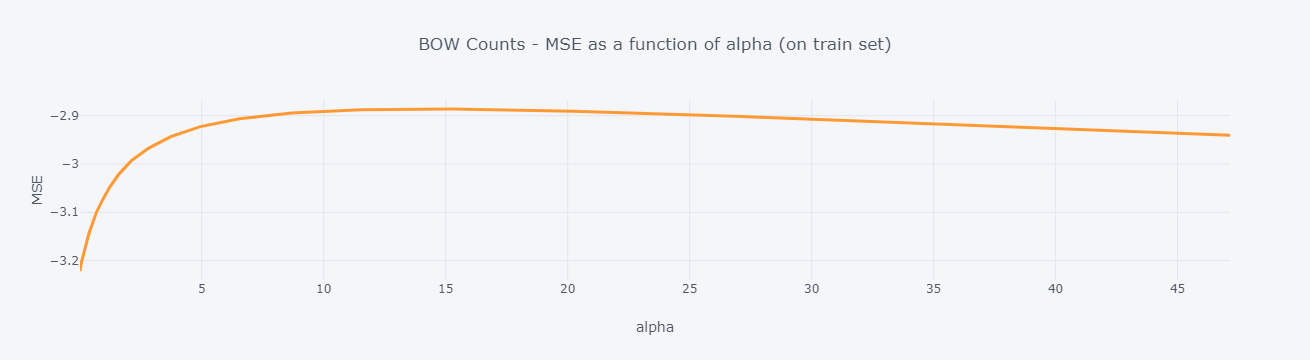

In [81]:
cv_results = pd.DataFrame(MSE_by_alpha, columns = ['alpha', 'MSE'])
cv_results.query('alpha < 50').set_index('alpha').MSE.iplot(title = 'BOW Counts - MSE as a function of alpha (on train set)', xTitle = 'alpha', yTitle = 'MSE', width = 3, hline=(0,0))

In [82]:
opt_alpha, max_MSE = cv_results.loc[cv_results.MSE.idxmax()]
print(opt_alpha, -max_MSE)

15.264179671752334 2.8861125006334434


#### Optimal Model : training the model with the best alpha, on the train set:

In [83]:
model = Ridge(alpha=opt_alpha)
model.fit(clean_bow_counts_train, train_data.points)

Ridge(alpha=15.264179671752334)

In [84]:
test_data['NLP_with_description_predicted_points'] = model.predict(clean_bow_counts_test)

In [85]:
NLP_with_description_predicted_points = calc_prediction_quality(test_data, 'NLP_with_description_predicted_points','points')
NLP_with_description_predicted_points

MSE    2.915874
MAE    1.345026
R2     0.694140
dtype: float64

In [86]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, NLP_with_description_predicted_points], index=['baseline_1', 'baseline_2','baseline_3', 'NLP_with_description_predicted_points'])
all_compared

,MSE,MAE,R2
baseline_1,9.534127,2.524274,-0.000082
baseline_2,9.034840,2.454526,0.052291
baseline_3,8.497766,2.362510,0.108628
NLP_with_description_predicted_points,2.915874,1.345026,0.694140


# Using both the text and other features

#### Using both the text and other features (encoded in the Boosting trees part)

In [153]:
features

['country',
 'province',
 'region_1',
 'region_2',
 'taster_name',
 'variety',
 'winery',
 'price']

In [154]:
from scipy.sparse import coo_matrix, hstack
from sklearn.preprocessing import StandardScaler

In [155]:
# scaler = StandardScaler()
# scaled_train = scaler.fit_transform(train_encoded_features.values)
# scaled_train_df = pd.DataFrame(scaled_train, index=train_encoded_features.index, columns=train_encoded_features.columns)

In [156]:
train_features_spares_matrix = coo_matrix(train_encoded_features)
train_united_features = hstack((clean_bow_counts_train ,train_features_spares_matrix))

In [157]:
train_features_spares_matrix.shape

(95990, 9)

#### Search for the best alpha on the Train set only :

In [158]:
%%capture
search_grid = np.logspace(-2, 4, num=50, endpoint=True, base=10.0)
MSE_by_alpha = []
for alpha in search_grid:
    model = Ridge(alpha=alpha)
    avg_score = cross_val_score(model, train_united_features, y = train_data.points, cv = 10, scoring = 'neg_mean_squared_error').mean()
    MSE_by_alpha.append((alpha,avg_score))

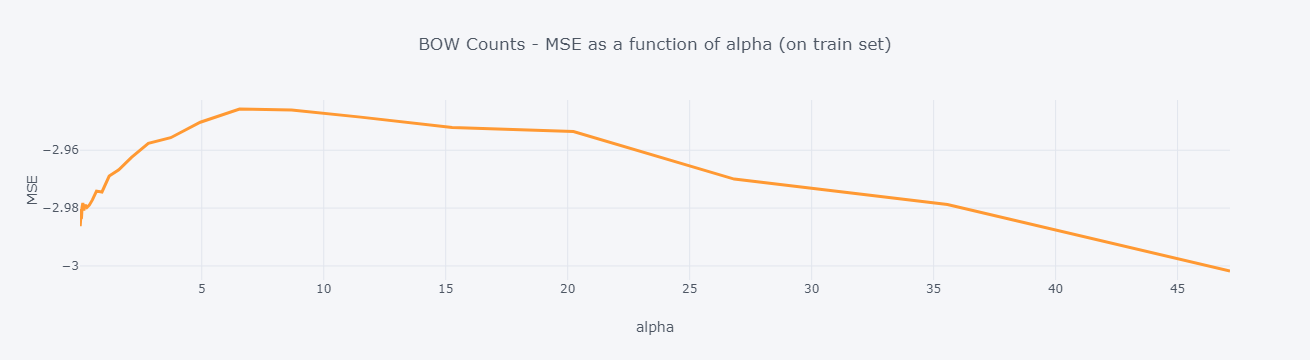

In [159]:
cv_results = pd.DataFrame(MSE_by_alpha, columns = ['alpha', 'MSE'])
cv_results.query('alpha < 50').set_index('alpha').MSE.iplot(title = 'BOW Counts - MSE as a function of alpha (on train set)', xTitle = 'alpha', yTitle = 'MSE', width = 3, hline=(0,0))

In [160]:
opt_alpha, max_MSE = cv_results.loc[cv_results.MSE.idxmax()]
print(opt_alpha, -max_MSE)

6.551285568595509 2.9457354403768052


#### Optimal Model : training the model with the best alpha, on the train set:

In [161]:
model = Ridge(alpha=opt_alpha)
model.fit(clean_bow_counts_train, train_data.points)

Ridge(alpha=6.551285568595509)

In [162]:
test_data['NLP_with_all_features_predicted_points'] = model.predict(clean_bow_counts_test)

In [163]:
NLP_with_all_features_predicted_points = calc_prediction_quality(test_data, 'NLP_with_all_features_predicted_points','points')
NLP_with_all_features_predicted_points

MSE    2.936796
MAE    1.348837
R2     0.691945
dtype: float64

In [164]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, NLP_with_description_predicted_points, NLP_with_all_features_predicted_points], index=['baseline_1', 'baseline_2','baseline_3', 'NLP_with_description_predicted_points', 'NLP_with_all_features_predicted_points'])
all_compared

,MSE,MAE,R2
baseline_1,9.534127,2.524274,-0.000082
baseline_2,9.034840,2.454526,0.052291
baseline_3,8.497766,2.362510,0.108628
NLP_with_description_predicted_points,2.915874,1.345026,0.694140
NLP_with_all_features_predicted_points,2.936796,1.348837,0.691945


# Classical NLP wothout outliers

country           AxesSubplot(0.125,0.657941;0.227941x0.222059)
province       AxesSubplot(0.398529,0.657941;0.227941x0.222059)
region_1       AxesSubplot(0.672059,0.657941;0.227941x0.222059)
region_2          AxesSubplot(0.125,0.391471;0.227941x0.222059)
taster_name    AxesSubplot(0.398529,0.391471;0.227941x0.222059)
variety        AxesSubplot(0.672059,0.391471;0.227941x0.222059)
winery               AxesSubplot(0.125,0.125;0.227941x0.222059)
price             AxesSubplot(0.398529,0.125;0.227941x0.222059)
points            AxesSubplot(0.672059,0.125;0.227941x0.222059)
dtype: object

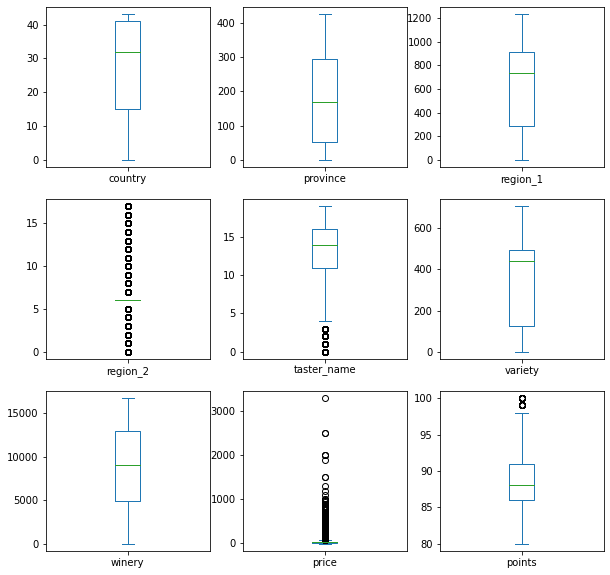

In [165]:
train_encoded_features.plot(kind='box', subplots=True, figsize=(10,10), layout=(3,3))

import numpy as np
from scipy import stats
train_encoded_features[(np.abs(stats.zscore(train_encoded_features)) < 3).all(axis=1)]


In [166]:
#removing the 'price' feature as it's showing a lot of outliars:
encoded_features2 = wine_reviews[categorical_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
encoded_features2['points'] = wine_reviews.points
encoded_features2.head()

,country,province,region_1,region_2,taster_name,variety,winery,points
0,22,332,424,6,9,691,11608,87
1,32,108,738,6,16,451,12956,87
2,41,269,1218,17,15,437,13018,87
3,41,218,549,6,0,480,14390,87
4,41,269,1218,17,15,441,14621,87


In [167]:
encoded_features2.shape

(119988, 8)

In [168]:
len(wine_reviews)

119988

In [169]:
train_encoded_features2 = encoded_features2[encoded_features2.index.isin(train_data.index)]
test_encoded_features2 = encoded_features2[encoded_features2.index.isin(test_data.index)]
assert(len(train_encoded_features2) + len(test_encoded_features2) == len(wine_reviews))

In [170]:
train_features_spares_matrix2 = coo_matrix(train_encoded_features2)
train_united_features2 = hstack((clean_bow_counts_train ,train_features_spares_matrix2))

In [171]:
%%capture
search_grid = np.logspace(-2, 4, num=50, endpoint=True, base=10.0)
MSE_by_alpha = []
for alpha in search_grid:
    model = Ridge(alpha=alpha)
    avg_score = cross_val_score(model, train_united_features2, y = train_data.points, cv = 10, scoring = 'neg_mean_squared_error').mean()
    MSE_by_alpha.append((alpha,avg_score))

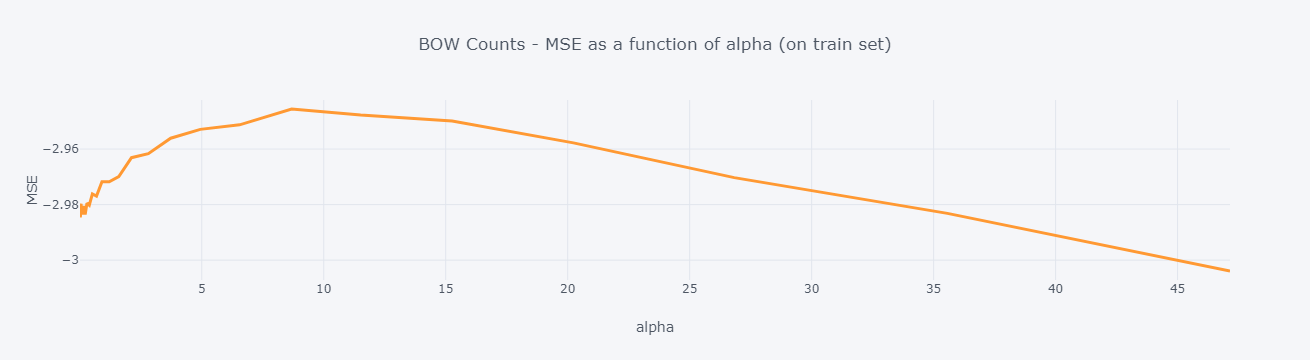

In [172]:
cv_results = pd.DataFrame(MSE_by_alpha, columns = ['alpha', 'MSE'])
cv_results.query('alpha < 50').set_index('alpha').MSE.iplot(title = 'BOW Counts - MSE as a function of alpha (on train set)', xTitle = 'alpha', yTitle = 'MSE', width = 3, hline=(0,0))

In [173]:
opt_alpha, max_MSE = cv_results.loc[cv_results.MSE.idxmax()]
print(opt_alpha, -max_MSE)

8.68511373751352 2.9455781113964434


In [174]:
model = Ridge(alpha=opt_alpha)
model.fit(clean_bow_counts_train, train_data.points)

Ridge(alpha=8.68511373751352)

In [175]:
test_data['NLP_with_description_predicted_points_without_outliers'] = model.predict(clean_bow_counts_test)

In [176]:
NLP_with_description_predicted_points_without_outliers = calc_prediction_quality(test_data, 'NLP_with_description_predicted_points_without_outliers','points')
NLP_with_description_predicted_points_without_outliers

MSE    2.924716
MAE    1.346306
R2     0.693212
dtype: float64

In [177]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, NLP_with_description_predicted_points, NLP_with_all_features_predicted_points,NLP_with_description_predicted_points_without_outliers], index=['baseline_1', 'baseline_2','baseline_3', 'NLP_with_description_predicted_points', 'NLP_with_all_features_predicted_points','NLP_with_description_predicted_points_without_outliers'])
all_compared

,MSE,MAE,R2
baseline_1,9.534127,2.524274,-0.000082
baseline_2,9.034840,2.454526,0.052291
baseline_3,8.497766,2.362510,0.108628
NLP_with_description_predicted_points,2.915874,1.345026,0.694140
NLP_with_all_features_predicted_points,2.936796,1.348837,0.691945
NLP_with_description_predicted_points_without_outliers,2.924716,1.346306,0.693212


# Tokenization

In [178]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, GlobalAveragePooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping

What is a good size for the vocabulary? 

In [179]:
wine_reviews.description.apply(lambda x: len(x.split(' '))).quantile([0.95, 0.99])

0.95    60.0
0.99    72.0
Name: description, dtype: float64

In [180]:
vocab_size = 32000
sequence_length = 60

# Use the text vectorization layer to normalize, split, and map strings to integers. Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    #standardize=lambda text: tf.strings.lower(text), # You can use your own normalization function here
    standardize='lower_and_strip_punctuation', # Or you can use a pre-made normalization function
    max_tokens=vocab_size,    
    split='whitespace',
    output_mode='int',
    name = 'Text_processing',
    output_sequence_length=sequence_length)

In [181]:
vectorize_layer.adapt(train_data['description'])

In [182]:
sample_description = train_data['description'].sample().iloc[0]
print(sample_description)
vectorize_layer(sample_description)

Full aromas of toasty oak, blackberry and vanilla feed into a saturated hard-pointed tartaric palate. Flavors of Christmas spice, oak and baked black fruits display hints of nutmeg and cola on a blocky hard finish. Drink through 2020.


<tf.Tensor: shape=(60,), dtype=int64, numpy=
array([  69,   17,    5,  234,   41,   49,    2,   63, 2747,  105,    4,
       1033,    1, 2920,   18,   10,    5, 2776,   34,   41,    2,  228,
         29,   47, 1781,  152,    5,  559,    2,  178,   15,    4, 1637,
        313,   20,   25,   61,  357,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int64)>

In [183]:
for token in vectorize_layer(sample_description).numpy()[:20]:
    print(f"{token} ---> ",vectorize_layer.get_vocabulary()[token])

69 --->  full
17 --->  aromas
5 --->  of
234 --->  toasty
41 --->  oak
49 --->  blackberry
2 --->  and
63 --->  vanilla
2747 --->  feed
105 --->  into
4 --->  a
1033 --->  saturated
1 --->  [UNK]
2920 --->  tartaric
18 --->  palate
10 --->  flavors
5 --->  of
2776 --->  christmas
34 --->  spice
41 --->  oak


# DNN with description only

#### Modeling

In [184]:
embedding_dim=16

dnn_model_with_average = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    GlobalAveragePooling1D(),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

In [185]:
dnn_model_with_average.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 16)            512000    
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 hidden_layer (Dense)        (None, 164)               2788      
                                                                 
 dropout_4 (Dropout)         (None, 164)               0         
                                                                 
 output_layer (Dense)        (None, 1)                

In [186]:
tf.keras.utils.plot_model(dnn_model_with_average, show_dtype=False, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [187]:
dnn_model_with_average.compile(
    optimizer=tf.optimizers.Adam(),
    loss='mean_absolute_error',
    metrics=['mean_squared_error','mean_absolute_error'])

In [188]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = dnn_model_with_average.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 7s 9ms/step - loss: 21.9356 - mean_squared_error: 1359.3676 - mean_absolute_error: 21.9356 - val_loss: 2.4599 - val_mean_squared_error: 9.1454 - val_mean_absolute_error: 2.4599
Epoch 2/20
750/750 [==============================] - 6s 8ms/step - loss: 3.4378 - mean_squared_error: 18.5437 - mean_absolute_error: 3.4378 - val_loss: 1.7157 - val_mean_squared_error: 4.6583 - val_mean_absolute_error: 1.7157
Epoch 3/20
750/750 [==============================] - 6s 8ms/step - loss: 3.1759 - mean_squared_error: 15.9075 - mean_absolute_error: 3.1759 - val_loss: 1.5010 - val_mean_squared_error: 3.5960 - val_mean_absolute_error: 1.5010
Epoch 4/20
750/750 [==============================] - 6s 9ms/step - loss: 3.0934 - mean_squared_error: 15.0987 - mean_absolute_error: 3.0934 - val_loss: 1.4586 - val_mean_squared_error: 3.3852 - val_mean_absolute_error: 1.4586
Epoch 5/20
750/750 [==============================] - 6s 8ms/step - loss: 3.0688 - mean_

### Simple NN Prediction & Evaluation

In [189]:
test_data['dnn_prediction'] = dnn_model_with_average.predict(test_data[text_col])

750/750 [==============================] - 1s 1ms/step


In [190]:
dnn_stats = calc_prediction_quality(test_data, 'dnn_prediction', target_col)
dnn_stats

MSE    3.170942
MAE    1.407540
R2     0.667384
dtype: float64

In [191]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, NLP_with_description_predicted_points, NLP_with_all_features_predicted_points,NLP_with_description_predicted_points_without_outliers,dnn_stats], index=['baseline_1', 'baseline_2','baseline_3', 'NLP_with_description_predicted_points', 'NLP_with_all_features_predicted_points','NLP_with_description_predicted_points_without_outliers','dnn_prediction'])
all_compared

,MSE,MAE,R2
baseline_1,9.534127,2.524274,-0.000082
baseline_2,9.034840,2.454526,0.052291
baseline_3,8.497766,2.362510,0.108628
NLP_with_description_predicted_points,2.915874,1.345026,0.694140
NLP_with_all_features_predicted_points,2.936796,1.348837,0.691945
NLP_with_description_predicted_points_without_outliers,2.924716,1.346306,0.693212
dnn_prediction,3.170942,1.407540,0.667384


# Descriptions words concatinated

In [192]:
from tensorflow.keras.layers import Reshape, Dense, Dropout
from tensorflow.keras import Sequential

In [193]:
embedding_dim=16

dnn_model_with_concatinated = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    Reshape((embedding_dim * sequence_length, ), name='concat_words'),
    Dense(768, activation='tanh', name='hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

In [194]:
dnn_model_with_concatinated.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 16)            512000    
                                                                 
 concat_words (Reshape)      (None, 960)               0         
                                                                 
 hidden_layer (Dense)        (None, 768)               738048    
                                                                 
 dropout_5 (Dropout)         (None, 768)               0         
                                                                 
 output_layer (Dense)        (None, 1)                 769       
                                                      

In [195]:
dnn_model_with_concatinated.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

In [196]:
tf.keras.utils.plot_model(dnn_model_with_concatinated, show_dtype=True, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [197]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = dnn_model_with_concatinated.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 12s 15ms/step - loss: 6.3367 - mean_squared_error: 267.9070 - mean_absolute_error: 6.3367 - val_loss: 1.5977 - val_mean_squared_error: 4.0862 - val_mean_absolute_error: 1.5977
Epoch 2/20
750/750 [==============================] - 11s 15ms/step - loss: 1.9490 - mean_squared_error: 6.0287 - mean_absolute_error: 1.9490 - val_loss: 1.3852 - val_mean_squared_error: 3.0888 - val_mean_absolute_error: 1.3852
Epoch 3/20
750/750 [==============================] - 11s 14ms/step - loss: 1.8528 - mean_squared_error: 5.4319 - mean_absolute_error: 1.8528 - val_loss: 1.3918 - val_mean_squared_error: 3.1002 - val_mean_absolute_error: 1.3918
Epoch 4/20
750/750 [==============================] - 11s 14ms/step - loss: 1.7949 - mean_squared_error: 5.1120 - mean_absolute_error: 1.7949 - val_loss: 1.3540 - val_mean_squared_error: 2.9632 - val_mean_absolute_error: 1.3540
Epoch 5/20
750/750 [==============================] - 11s 14ms/step - loss: 1.7643 - m

In [198]:
test_data['dnn_prediction_with_concatinated'] = dnn_model_with_concatinated.predict(test_data[text_col])

750/750 [==============================] - 2s 2ms/step


In [199]:
dnn_prediction_with_concatinated = calc_prediction_quality(test_data, 'dnn_prediction_with_concatinated', target_col)
dnn_prediction_with_concatinated

MSE    2.963187
MAE    1.353952
R2     0.689177
dtype: float64

In [200]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, NLP_with_description_predicted_points, NLP_with_all_features_predicted_points,NLP_with_description_predicted_points_without_outliers,dnn_stats,dnn_prediction_with_concatinated], index=['baseline_1', 'baseline_2','baseline_3', 'NLP_with_description_predicted_points', 'NLP_with_all_features_predicted_points','NLP_with_description_predicted_points_without_outliers','dnn_prediction','dnn_prediction_with_concatinated'])
all_compared

,MSE,MAE,R2
baseline_1,9.534127,2.524274,-0.000082
baseline_2,9.034840,2.454526,0.052291
baseline_3,8.497766,2.362510,0.108628
NLP_with_description_predicted_points,2.915874,1.345026,0.694140
NLP_with_all_features_predicted_points,2.936796,1.348837,0.691945
NLP_with_description_predicted_points_without_outliers,2.924716,1.346306,0.693212
dnn_prediction,3.170942,1.407540,0.667384
dnn_prediction_with_concatinated,2.963187,1.353952,0.689177


# LSTM

In [218]:
vocab_size = 32000
sequence_length = 60

vectorize_layer_for_lstm = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=vocab_size,    
    split='whitespace',
    output_mode='int',
    name = 'Text_processing',
    output_sequence_length=sequence_length)

vectorize_layer_for_lstm.adapt(train_data['description'])

#### Modeling

In [219]:
from keras.layers import LSTM,Bidirectional
embedding_dim=16

lstm_nodel = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer_for_lstm,
    Embedding(vocab_size, embedding_dim , input_length = sequence_length , name="embedding"),
    LSTM(32,activation="tanh",name='lstm_hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

lstm_nodel.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 16)            512000    
                                                                 
 lstm_hidden_layer (LSTM)    (None, 32)                6272      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 518,305
Trainable params: 518,305
Non-trainable params: 0
________________________________________________

In [220]:
lstm_nodel.compile(
    optimizer=tf.optimizers.Adam(),
    loss='mean_absolute_error',
    metrics=['mean_squared_error','mean_absolute_error'])

In [221]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = lstm_nodel.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=32,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
3000/3000 [==============================] - 54s 17ms/step - loss: 1973.3729 - mean_squared_error: 1973.3729 - mean_absolute_error: 39.0127 - val_loss: 109.8988 - val_mean_squared_error: 109.8988 - val_mean_absolute_error: 10.0180
Epoch 2/20
3000/3000 [==============================] - 51s 17ms/step - loss: 77.8950 - mean_squared_error: 77.8950 - mean_absolute_error: 7.0155 - val_loss: 10.1421 - val_mean_squared_error: 10.1421 - val_mean_absolute_error: 2.5707
Epoch 3/20
3000/3000 [==============================] - 51s 17ms/step - loss: 66.6888 - mean_squared_error: 66.6888 - mean_absolute_error: 6.5066 - val_loss: 10.0804 - val_mean_squared_error: 10.0804 - val_mean_absolute_error: 2.5620
Epoch 4/20
3000/3000 [==============================] - 51s 17ms/step - loss: 65.8248 - mean_squared_error: 65.8248 - mean_absolute_error: 6.4786 - val_loss: 9.8605 - val_mean_squared_error: 9.8605 - val_mean_absolute_error: 2.5263
Epoch 5/20
3000/3000 [==============================] - 51

In [222]:
test_data['dnn3_lstm_prediction'] = lstm_nodel.predict(test_data[text_col])

750/750 [==============================] - 4s 5ms/step


In [223]:
dnn3_lstm_prediction = calc_prediction_quality(test_data, 'dnn3_lstm_prediction', target_col)
dnn3_lstm_prediction

MSE    3.138933
MAE    1.403063
R2     0.670742
dtype: float64

In [224]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, NLP_with_description_predicted_points, NLP_with_all_features_predicted_points,NLP_with_description_predicted_points_without_outliers,dnn_stats,dnn_prediction_with_concatinated,dnn3_lstm_prediction], index=['baseline_1', 'baseline_2','baseline_3', 'NLP_with_description_predicted_points', 'NLP_with_all_features_predicted_points','NLP_with_description_predicted_points_without_outliers','dnn_prediction','dnn_prediction_with_concatinated','dnn3_lstm_prediction'])
all_compared

,MSE,MAE,R2
baseline_1,9.534127,2.524274,-0.000082
baseline_2,9.034840,2.454526,0.052291
baseline_3,8.497766,2.362510,0.108628
NLP_with_description_predicted_points,2.915874,1.345026,0.694140
NLP_with_all_features_predicted_points,2.936796,1.348837,0.691945
NLP_with_description_predicted_points_without_outliers,2.924716,1.346306,0.693212
dnn_prediction,3.170942,1.407540,0.667384
dnn_prediction_with_concatinated,2.963187,1.353952,0.689177
dnn3_lstm_prediction,3.138933,1.403063,0.670742


# Using external embedding (description feature only)

In [285]:
import os
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras

path_to_glove_file = "D:/Users/1/Desktop/DS-Thechnion/Python_ML-2022/Final project/data/glove.6B.100d.txt"

In [286]:
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [287]:
num_tokens = len(vectorize_layer.get_vocabulary()) + 2
word_index = dict(zip(vectorize_layer.get_vocabulary(), range(len(vectorize_layer.get_vocabulary()))))

embedding_dim = 100
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [288]:
external_embedding_model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(num_tokens,embedding_dim, embeddings_initializer= tf.keras.initializers.Constant(embedding_matrix), name="embedding" , trainable=False),
    GlobalAveragePooling1D(),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

In [289]:
external_embedding_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 100)           3200200   
                                                                 
 global_average_pooling1d_9   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 hidden_layer (Dense)        (None, 164)               16564     
                                                                 
 dropout_18 (Dropout)        (None, 164)               0         
                                                                 
 output_layer (Dense)        (None, 1)               

In [290]:
external_embedding_model.compile(optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

In [291]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = external_embedding_model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 5s 7ms/step - loss: 22.7125 - mean_squared_error: 1189.5813 - mean_absolute_error: 22.7125 - val_loss: 2.3428 - val_mean_squared_error: 8.7798 - val_mean_absolute_error: 2.3428
Epoch 2/20
750/750 [==============================] - 5s 6ms/step - loss: 3.6219 - mean_squared_error: 20.7344 - mean_absolute_error: 3.6219 - val_loss: 2.3252 - val_mean_squared_error: 8.5569 - val_mean_absolute_error: 2.3252
Epoch 3/20
750/750 [==============================] - 5s 6ms/step - loss: 3.6060 - mean_squared_error: 20.5354 - mean_absolute_error: 3.6060 - val_loss: 2.2971 - val_mean_squared_error: 8.3105 - val_mean_absolute_error: 2.2971
Epoch 4/20
750/750 [==============================] - 5s 6ms/step - loss: 3.5143 - mean_squared_error: 19.5157 - mean_absolute_error: 3.5143 - val_loss: 2.0482 - val_mean_squared_error: 6.7117 - val_mean_absolute_error: 2.0482
Epoch 5/20
750/750 [==============================] - 5s 6ms/step - loss: 3.3842 - mean_

In [292]:
test_data['External_Embedding'] = external_embedding_model.predict(test_data[text_col])

750/750 [==============================] - 1s 1ms/step


In [293]:
External_Embedding = calc_prediction_quality(test_data, 'External_Embedding', target_col)
External_Embedding

MSE    4.970461
MAE    1.770003
R2     0.478624
dtype: float64

In [294]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, NLP_with_description_predicted_points, NLP_with_all_features_predicted_points,NLP_with_description_predicted_points_without_outliers,dnn_stats,dnn_prediction_with_concatinated,dnn3_lstm_prediction,External_Embedding], index=['baseline_1', 'baseline_2','baseline_3', 'NLP_with_description_predicted_points', 'NLP_with_all_features_predicted_points','NLP_with_description_predicted_points_without_outliers','dnn_prediction','dnn_prediction_with_concatinated','dnn3_lstm_prediction','External_Embedding'])
all_compared

,MSE,MAE,R2
baseline_1,9.534127,2.524274,-0.000082
baseline_2,9.034840,2.454526,0.052291
baseline_3,8.497766,2.362510,0.108628
NLP_with_description_predicted_points,2.915874,1.345026,0.694140
NLP_with_all_features_predicted_points,2.936796,1.348837,0.691945
NLP_with_description_predicted_points_without_outliers,2.924716,1.346306,0.693212
dnn_prediction,3.170942,1.407540,0.667384
dnn_prediction_with_concatinated,2.963187,1.353952,0.689177
dnn3_lstm_prediction,3.138933,1.403063,0.670742
External_Embedding,4.970461,1.770003,0.478624
